In [1]:
from gsnn.optim.InputEdgeInferrer import InputEdgeInferrer
import torch

from gsnn_lib.data.LincsDataset import LincsDataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np 

from matplotlib import pyplot as plt

# auto reload imports 
%load_ext autoreload
%autoreload 2

In [2]:
targ = pd.read_csv('../extdata/targetome_with_broad_ids.csv')
targ.head()

,pert_id,Target_UniProt,Target_Species,Assay_Type,Assay_Relation,Assay_Value,EvidenceLevel_Assigned,Database
0,BRD-K56343971,P04049,Homo sapiens,IC50,=,48.0,III,BindingDB
1,BRD-K56343971,P04049,Homo sapiens,IC50,=,NaN,III,IUPHAR
2,BRD-K56343971,P04049,Homo sapiens,IC50,=,NaN,III,IUPHAR
3,BRD-K56343971,P00533,Homo sapiens,IC50,>,10000.0,III,BindingDB
4,BRD-K56343971,P15056,Homo sapiens,NaN,NaN,NaN,I,Therapeutic Target Database


In [5]:
targ.pert_id.unique().shape

(70,)

In [ ]:
targ[lambda x: x.pert_id == 'BRD-K85606544']

,pert_id,Target_UniProt,Target_Species,Assay_Type,Assay_Relation,Assay_Value,EvidenceLevel_Assigned,Database


In [52]:
model = torch.load('/home/teddy/local/gsnn-lib/output/lincs/GSNN/69cd08b2-2a61-412d-965a-ec6f2425fc7e/fold_0_lincs_splits/best_model.pt')
model.eval()
model.cpu()

/tmp/ipykernel_18650/986624438.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/teddy/local/gsnn-lib/output/lincs/GSNN/69cd08b2-2a61-412d-965a-e

GSNN(
  (ResBlocks): ModuleList(
    (0-9): 10 x ResBlock(
      (lin_in): SparseLinear(
        (conv): Conv()
      )
      (norm): BatchNorm1d(28539, eps=0.01, momentum=0.1, affine=True, track_running_stats=True)
      (lin_out): SparseLinear(
        (conv): Conv()
      )
      (nonlin): LeakyReLU(negative_slope=0.01)
    )
  )
)

In [53]:
root = '/home/teddy/local/gsnn-lib/proc/lincs'

data = torch.load(f'{root}/data.pt')

split_dict = torch.load('/home/teddy/local/gsnn-lib/proc/lincs/partitions/fold_0_lincs_splits.pt')

condinfo = pd.read_csv(f'{root}/conditions_meta.csv', sep=',')

/tmp/ipykernel_18650/2618367688.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f'{root}/data.pt')
/tmp/ipykernel_18650/2618367688.py:5: FutureWarning:

In [54]:

train_dataset = LincsDataset(root=root, cond_ids=split_dict['train_obs'], data=data, cond_meta=condinfo)
train_loader = DataLoader(train_dataset, batch_size=50, num_workers=10, shuffle=False, persistent_workers=False)


In [123]:
xs = [] 
ys = [] 
cond_ids = [] 

for i, (x, y, cond_id) in enumerate(train_loader):
    print(f'progress: {i}/{len(train_loader)}', end='\r')
    xs.append(x)
    ys.append(y)
    cond_ids += cond_id

x = torch.cat(xs, dim=0)
y = torch.cat(ys, dim=0)

res = {'cell':[], 'drug':[], 'dose':[], 'time':[]}
for id in cond_ids: 
    cell, drug, dose, time = id.split('__')
    res['cell'].append(cell)
    res['drug'].append(drug)
    res['dose'].append(dose)
    res['time'].append(time)
res = pd.DataFrame(res)
res.head()

,cell,drug,dose,time
0,22RV1,BRD-A00376169,1.11111,24.0
1,22RV1,BRD-A00376169,3.33333,24.0
2,22RV1,BRD-A00376169,10.0,24.0
3,22RV1,BRD-A01320529,0.1,24.0
4,22RV1,BRD-A01320529,1.0,24.0


In [126]:
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')
res2 = res.merge(druginfo, left_on='drug', right_on='pert_id')
res2 = res2.groupby(['pert_id', 'cmap_name']).count()[['cell']].sort_values('cell', ascending=False).reset_index()
res2.head(10)

,pert_id,cmap_name,cell
0,BRD-K49328571,dasatinib,13800
1,BRD-K23984367,sorafenib,9306
2,BRD-K16730910,regorafenib,6624
3,BRD-K59369769,tozasertib,5712
4,BRD-K27305650,LY-294002,4340
5,BRD-K92723993,imatinib,3708
6,BRD-K77625799,vandetanib,3591
7,BRD-K44227013,ponatinib,3090
8,BRD-K71035033,masitinib,2835
9,BRD-K51544265,cabozantinib,2448


In [127]:
res2[lambda x: x.cmap_name == 'neratinib']

,pert_id,cmap_name,cell
61,BRD-K85606544,neratinib,372


In [128]:
drg = 'BRD-K85606544' # neratinib #'BRD-K81418486' # vorinostat 
drg_res = res[lambda x: x.drug == drg]
drg_x = x[drg_res.index]
drg_y = y[drg_res.index]

In [129]:
src,dst = data.edge_index_dict['input', 'to', 'function'].detach().cpu().numpy()
src_names = np.array(data.node_names_dict['input'])[src]
dst_names = np.array(data.node_names_dict['function'])[dst]

dti_mask = torch.tensor(['DRUG__' in name for name in src_names])
e0_idxs = model.input_edge_mask.detach().cpu().nonzero(as_tuple=True)[0]
e0_idxs = e0_idxs[dti_mask]

print( '# of DTIs:', sum(dti_mask)) 
print( 'e0_idxs size:', e0_idxs.size())

# of DTIs: tensor(3196)
e0_idxs size: torch.Size([3196])


In [130]:
e_targets = torch.zeros(model.edge_index.shape[1], dtype=torch.bool, device='cpu')
e_targets[e0_idxs] = True
e_targets.sum()

tensor(3196)

In [131]:
input_idx = torch.tensor([data.node_names_dict['input'].index(f'DRUG__{drg}')], dtype=torch.long)
print(input_idx)
# NOTE: this does not exclude omic edges from comparison 
# TODO: only compare to DTI edges. Comparing to omics edges doesn't really make sense. 
# TODO: instead of using ttest for significance testing use quantile ? Prob(w > 0) + prob(w < 0) 

tensor([5])


In [132]:
torch.cuda.empty_cache()

iei_kwargs = {'iters':100, 'lr':1e-3, 'wd':0, 'dropout':0.75, 'n_bootstrap':10, 'bootstrap_p':0.5, 'device':'cuda', 'batch_size':64}

iei = InputEdgeInferrer(model, data, drg_x, drg_y)
res = iei.infer(input_idx=input_idx, edge_targets=e_targets, **iei_kwargs)
res.sort_values('pval', ascending=True).head(10)

[bootstrap sample: 9] --> iter: 99 | train loss: 0.574 || val0: 0.6517, val loss: 0.5884]


,input_idx,func_idx,src,dst,weight,pval,prop_gt_zero,prop_lt_zero,pval_adj,in_graph
3154,5,957,DRUG__BRD-K85606544,PROTEIN__P01258,-0.041010,4.234683e-12,0.0,1.0,1.353405e-08,False
1010,5,762,DRUG__BRD-K85606544,PROTEIN__O94768,-0.037325,3.327970e-11,0.0,1.0,4.747470e-08,False
1228,5,3641,DRUG__BRD-K85606544,PROTEIN__Q6DT37,0.049568,4.456324e-11,1.0,0.0,4.747470e-08,False
781,5,2581,DRUG__BRD-K85606544,PROTEIN__P57058,0.045722,1.346954e-10,1.0,0.0,1.076216e-07,False
2026,5,3060,DRUG__BRD-K85606544,PROTEIN__Q13043,0.039740,2.366379e-10,1.0,0.0,1.086628e-07,False
1571,5,2458,DRUG__BRD-K85606544,PROTEIN__P52564,0.030836,2.853726e-10,1.0,0.0,1.086628e-07,False
1558,5,2369,DRUG__BRD-K85606544,PROTEIN__P49840,0.038657,3.010379e-10,1.0,0.0,1.086628e-07,False
823,5,3148,DRUG__BRD-K85606544,PROTEIN__Q13470,-0.046089,3.029997e-10,0.0,1.0,1.086628e-07,False
1584,5,2581,DRUG__BRD-K85606544,PROTEIN__P57058,0.047083,3.197791e-10,1.0,0.0,1.086628e-07,False
962,5,5300,DRUG__BRD-K85606544,PROTEIN__Q9Y2U5,0.041614,3.622615e-10,1.0,0.0,1.086628e-07,False


In [133]:
# https://lincs.hms.harvard.edu/db/sm/10018-101/
ner_targets1 = 'BLK, EGFR, EIF2AK4, ERBB2, ERBB3, ERBB4, MAP2K1, MAP2K2, MAP2K5, MAP3K19, MAP3K4, MAP4K1, MAP4K3, MAP4K5, MINK1, PAK2, SLK, STK10, STK24, STK25, STK26, STK3, AXL, BTK, CHEK2, CSF1R, CSK, CSNK1E, FER, FES, GAK, HCK, LCK, LYN, MAP2K7, MAP3K12, MAP3K13, MAP3K2, MAP3K3, MAP4K2, MAP4K4, MERTK, NEK2, NUAK2, PAK1, PRKD1, SIK1, SIK1B, STK17A, STK33, STK4, TIE1, TNIK, TNK2, TPTEP2-CSNK1E, YES1'.split(', ')
ner_targets2 = 'AXL, BTK, CHEK2, CSF1R, CSK, CSNK1E, FER, FES, GAK, HCK, LCK, LYN, MAP2K7, MAP3K12, MAP3K13, MAP3K2, MAP3K3, MAP4K2, MAP4K4, MERTK, NEK2, NUAK2, PAK1, PRKD1, SIK1, SIK1B, STK17A, STK33, STK4, TIE1, TNIK, TNK2, TPTEP2-CSNK1E, YES1'.split(', ')
ner_targets3 = 'ABL1, BUB1B-PAK6, CAMK1D, CDK16, CDK7, CHEK1, CSNK1G2, CSNK1G3, DSTYK, EPHB6, FGR, FLT3, FYN, HIPK4, INSR, INSRR, IRAK1, JAK3, MAP3K10, MAP3K11, MAP3K20, MAP3K9, MAPK10, MAPK8, MAST1, MELK, MET, MST1R, NEK3, NUAK1, PAK6, PRKD2, PRKD3, PTK2, PTK2B, RPS6KA1, RPS6KA2, SIK2, SRC, STK17B, STK32B, STK35, STK36, SYK, TAOK3, TEK, TXK, WEE1, WEE2'.split(', ')
ner_not_targs = 'ABL2, ACVR1, ACVR1B, ACVR2A, ACVR2B, ACVRL1, AKT1, AKT2, AKT3, ALK, ANKK1, AURKA, AURKB, AURKC, BMP2K, BMPR1A, BMPR1B, BMPR2, BMX, BRAF, BRSK1, BRSK2, C8orf44-SGK3, CAMK1, CAMK1G, CAMK2A, CAMK2B, CAMK2D, CAMK2G, CAMK4, CAMKK1, CAMKK2, CASK, CDC42BPA, CDC42BPB, CDC42BPG, CDK11A, CDK11B, CDK13, CDK14, CDK15, CDK17, CDK18, CDK19, CDK3, CDK5, CDK8, CDK9, CDKL1, CDKL2, CDKL3, CDKL5, CHUK, CIT, CLK1, CLK2, CLK3, CLK4, COQ8A, COQ8B, CSNK1A1, CSNK1A1L, CSNK1G1, CSNK2A1, DAPK1, DAPK2, DAPK3, DCLK1, DCLK2, DCLK3, DDR1, DDR2, DMPK, DYRK1A, DYRK1B, EIF2AK1, EIF2AK2, EPHA1, EPHA2, EPHA3, EPHA4, EPHA5, EPHA6, EPHA7, EPHA8, EPHB1, EPHB2, EPHB3, EPHB4, ERN1, FGFR1, FGFR2, FGFR3, FGFR4, FLT1, FLT4, FPGT-TNNI3K, FRK, GRK1, GRK7, GSK3A, GSK3B, HIPK3, HUNK, ICK, IGF1R, IKBKB, IKBKE, IRAK3, IRAK4, JAK1, KDR, KIT, LATS1, LATS2, LIMK1, LIMK2, LRRK2, LTK, MAK, MAP2K3, MAP2K6, MAP3K1, MAP3K15, MAP3K5, MAP3K6, MAP3K7, MAPK1, MAPK11, MAPK12, MAPK13, MAPK14, MAPK15, MAPK3, MAPK4, MAPK6, MAPK7, MAPKAPK2, MAPKAPK5, MARK1, MARK2, MARK4, MKNK2, MTOR, MUSK, MYLK2, MYLK3, MYLK4, MYO3A, MYO3B, NEK4, NEK5, NEK6, NEK7, NEK9, NIM1K, NLK, NTRK1, NTRK2, NTRK3, PAK3, PAK4, PDGFRA, PDPK1, PF3D7_0217500, PF3D7_1356900, PHKG1, PHKG2, PI4KB, PIK3C2B, PIK3C2G, PIK3CA, PIK3CB, PIK3CD, PIK3CG, PIM1, PIM2, PIM3, PIP4K2B, PIP4K2C, PIP5K1A, PIP5K1C, PKMYT1, PKN1, pknB, PLK2, PLK3, PLK4, PRKAA1, PRKAA2, PRKACA, PRKACB, PRKCD, PRKCE, PRKCH, PRKCI, PRKCQ, PRKG1, PRKG2, PRKX, PRPF4B, PTK6, RAF1, RET, RIOK3, RIPK1, RIPK2, ROCK1, ROCK2, ROS1, RPS6KA3, RPS6KA4, RPS6KA5, RPS6KA6, RPS6KB1, SBK1, SBK3, SGK3, SRMS, SRPK1, SRPK2, SRPK3, STK11, STK16, STK32A, STK32C, STK38, STK38L, STK39, TAOK1, TAOK2, TBK1, TESK1, TGFBR1, TGFBR2, TLK1, TLK2, TNK1, TNNI3K, TRPM6, TSSK1B, TTK, TYK2, TYRO3, ULK1, ULK2, ULK3, ZAP70'.split(', ')

ner_targs = ner_targets1 + ner_targets2 + ner_targets3

overlap = set(ner_targs).intersection(set(ner_not_targs))
len(overlap)

0

In [142]:
geneinfo = pd.read_csv('/home/teddy/local/gsnn-lib/extdata/omnipath_uniprot2genesymb.tsv', sep='\t')
res2 = res.assign(dst_uniprot=lambda xx: [x.split('__')[1] for x in xx.dst]).merge(geneinfo, left_on='dst_uniprot', right_on='From', how='left')
res2 = res2.assign(pert_id=lambda xx: [x.split('__')[1] for x in xx.src])
res2 = res2.rename(columns={'To':'gene_symbol'})
res2 = res2.assign(ner_targets = lambda xx: [x in ner_targs for x in xx.gene_symbol])
res2 = res2.assign(ner_not_targets = lambda xx: [x in ner_not_targs for x in xx.gene_symbol])

res2.sort_values('pval', ascending=True)[['pert_id', 'weight', 'pval_adj', 'prop_gt_zero', 'in_graph', 'gene_symbol', 'ner_targets', 'ner_not_targets']].head(25)

,pert_id,weight,pval_adj,prop_gt_zero,in_graph,gene_symbol,ner_targets,ner_not_targets
3154,BRD-K85606544,-0.041010,1.353405e-08,0.0,False,CALCA,False,False
1010,BRD-K85606544,-0.037325,4.747470e-08,0.0,False,STK17B,True,False
1228,BRD-K85606544,0.049568,4.747470e-08,1.0,False,CDC42BPG,False,True
781,BRD-K85606544,0.045722,1.076216e-07,1.0,False,HUNK,False,True
2026,BRD-K85606544,0.039740,1.086628e-07,1.0,False,STK4,True,False
1571,BRD-K85606544,0.030836,1.086628e-07,1.0,False,MAP2K6,False,True
1558,BRD-K85606544,0.038657,1.086628e-07,1.0,False,GSK3A,False,True
823,BRD-K85606544,-0.046089,1.086628e-07,0.0,False,TNK1,False,True
1584,BRD-K85606544,0.047083,1.086628e-07,1.0,False,HUNK,False,True
962,BRD-K85606544,0.041614,1.086628e-07,1.0,False,MAP3K2,True,False


In [143]:
from sklearn.metrics import roc_auc_score

In [145]:
roc_auc_score(res2.ner_targets, res2.weight)

0.5025010815487778

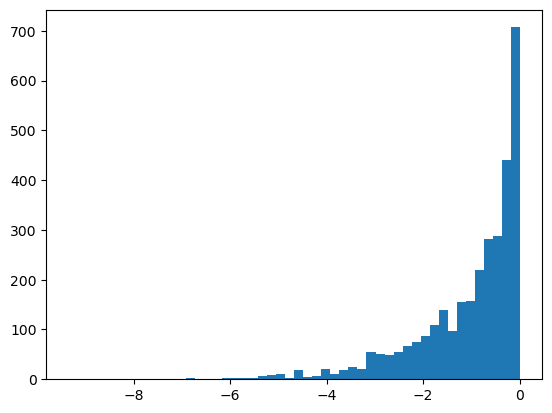

In [91]:
plt.figure()
plt.hist(np.log10(res.pval_adj), bins=50)
plt.show()